## Imports

In [13]:
import sys
import os
sys.path.insert(0, os.path.abspath('/home/eli/projects/ner-german-telegram/src'))

In [14]:
import pandas as pd
import numpy as np
import torch
from datasets import load_dataset
from seqeval.metrics import f1_score, precision_score, recall_score, accuracy_score
from collections import Counter, defaultdict
from transformers import AutoTokenizer, AutoModelForTokenClassification, AutoConfig, DataCollatorForTokenClassification 
from transformers import TrainingArguments, Trainer
from transformers import EarlyStoppingCallback
from datasets import load_dataset, Dataset, load_metric, DatasetDict
from collections import Counter, defaultdict
import seaborn as sns
from matplotlib import pyplot as plt

## Model

In [15]:
model_name = 'distilbert-base-multilingual-cased'

### About the model

"This model is a distilled version of the BERT base multilingual model. This model is cased: it does make a difference between english and English.

The model is trained on the concatenation of Wikipedia in 104 different languages listed [here](https://github.com/google-research/bert/blob/master/multilingual.md#list-of-languages) . The model has 6 layers, 768 dimension and 12 heads, totalizing 134M parameters (compared to 177M parameters for mBERT-base). On average DistilmBERT is twice as fast as mBERT-base.

We encourage to check BERT base multilingual model to know more about usage, limitations and potential biases.

https://huggingface.co/distilbert-base-multilingual-cased

## Dataset

In [19]:
dataset_name = 'telegram'

## Tokenizer

In [20]:
tokenizer = AutoTokenizer.from_pretrained(model_name) # more params defined in method tokenize_and_align_labels()

## Data collator

In [21]:
data_collator = DataCollatorForTokenClassification(tokenizer)

## Training params

In [22]:
NUM_EPOCHS = 10
BATCH_SIZE = 2
LOGGING_STRATEGY='epoch'
OUTPUT_DIR = f'../../../../../models/{model_name}-{dataset_name}-{NUM_EPOCHS}_epochs'
OVERWRITE_OUTPUT_DIR = True # only for first experiments
LOG_LEVEL = 'error'
EVALUATION_STRATEGY = 'epoch'
SAVE_STRATEGY ='epoch'
WEIGHT_DECAY = 0.01 # The weight decay to apply (if not zero) to all layers except all bias and LayerNorm weights in AdamW optimizer.
CALLBACK = EarlyStoppingCallback(early_stopping_patience=3)
LOAD_BEST_MODEL_AT_END = True,
METRIC_FOR_BEST_MODEL='eval_loss'

## Check GPU and set up torch device

In [23]:
# check gpu
torch.cuda.is_available()

True

In [24]:
# create torch device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load dataset

In [70]:
df = pd.read_json('../../../NER/prepare_data/telegram_dataset/data_prepared/ds_telegram.json')

In [71]:
print(f"Dataset contains {len(df)} rows with columns {df.columns.values}.")

Dataset contains 500 rows with columns ['id' 'tokens' 'ner_tags'].


In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        500 non-null    object
 1   tokens    500 non-null    object
 2   ner_tags  500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


In [73]:
# df = df.dropna() # only needed in case of null values

In [74]:
df.head()

id  \
0   Demotermine125028861058202021-02-02 12:42:26   
1   Demotermine125028861034202020-10-27 21:36:50   
2  Demotermine1250288610304832021-12-07 07:05:19   
3   Demotermine125028861040852020-11-22 09:54:32   
4  Demotermine1250288610131262021-07-28 21:41:05   

                                              tokens  \
0  [💚, Bitte, kommt, wieder, zahlreich, nach, Poi...   
1  [Ludwigsburg, 01112020, @querdenken7141, @EfAu...   
2  [Lichtermeer, am, 06.12.2021, vorm, Rathaus, i...   
3  [https://demo.terminkalender.top, /, Aktualisi...   
4  [Bodo, Schiffmann, Interview, mit, ARD, (, Kob...   

                                            ner_tags  
0  [O, O, O, O, O, O, B-LOC, O, B-ACTION, O, O, B...  
1                        [B-LOC, B-DATE, O, O, O, O]  
2  [B-ACTION, O, B-DATE, O, B-LOC, O, B-LOC, O, B...  
3                  [O, O, O, O, O, O, O, O, O, O, O]  
4  [B-PER, I-PER, O, O, B-ORG, O, B-LOC, O, B-DAT...

## Methods

In [75]:
def show_example(split='train', idx=0):
    example = ds[split][idx]
    return pd.DataFrame([example['tokens'], example['ner_tags_str']], ['tokens', 'tags'])

def get_entity_freqs(ds):
    split2freqs = defaultdict(Counter)

    for split, dataset in ds.items():
        for row in dataset['ner_tags_str']:
            for tag in row: 
                if tag.startswith('B'):
                    tag_type = tag.split('-')[1]
                    split2freqs[split][tag_type] += 1
    return pd.DataFrame.from_dict(split2freqs, orient='index')

In [76]:
def get_indices_and_tags():
    
    tags = ['O', 
            'B-DATE', 'I-DATE', 
            'B-LOC', 'I-LOC', 
            'B-ORG', 'I-ORG',
            'B-PER', 'I-PER',
            'B-TIME', 'I-TIME',
            'B-ACTION',
            'I-ACTION']
    
    index2tag = {idx: tag for idx, tag in enumerate(tags)}
    tag2index = {tag: idx for idx, tag in enumerate(tags)}    
    
    #print(f"tags: {tags}\n\nindex2tag: {index2tag}\n\ntag2index: {tag2index}")
    return tags, index2tag, tag2index


def ner_tags_str2id(ner_tags_str):
    
    tag_ids = []

    for tag in ner_tags_str:         
        idx = tag2index[tag]
        tag_ids.append(int(idx))
        
    return tag_ids


def tokenize_and_align_labels(examples):
    
    tokenized_inputs = tokenizer(
        examples['tokens'], 
        padding='max_length',
        truncation=True, 
        is_split_into_words=True
    )    
    
    labels = []
    
    for idx, label in enumerate(examples['ner_tags']):
        word_ids = tokenized_inputs.word_ids(batch_index=idx)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None or word_idx == previous_word_idx:
                label_ids.append(-100)
            else: 
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs['labels'] = labels
    return tokenized_inputs


def encode_dataset(corpus, columns_to_remove=['ner_tags', 'tokens', 'ner_tags_str', '__index_level_0__']):
    return corpus.map(tokenize_and_align_labels, 
                      batched=True,
                      remove_columns=columns_to_remove)

In [1]:
# Evaluation

def align_predictions(predictions, label_ids):
    preds = np.argmax(predictions, axis=2)
    batch_size, seq_len = preds.shape
    labels_list, preds_list = [], []
    
    for batch_idx in range(batch_size):
        example_labels, example_preds = [], []
        
        for seq_idx in range(seq_len):
            # Ignore label IDs = -100
            if label_ids[batch_idx, seq_idx] != -100:
                example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
                example_preds.append(index2tag[preds[batch_idx][seq_idx]])
        labels_list.append(example_labels)
        preds_list.append(example_preds)
        
    return preds_list, labels_list    


def compute_metrics(eval_pred):
    y_pred, y_true = align_predictions(eval_pred.predictions, 
                                       eval_pred.label_ids)
    
    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    
    return {'f1': f1, 
            'precision': precision,
            'recall': recall,
            'accuracy': accuracy}


def get_training_history(trainer):
    df = pd.DataFrame(trainer.state.log_history)[['epoch','loss' ,'eval_loss', 'eval_f1', 'eval_precision', 'eval_recall', 'eval_accuracy']]
    df = df.rename(columns={"epoch":"epoch",
                            "loss": "training_loss", 
                            "eval_loss": "validation_loss", 
                            "eval_f1":"f1", 
                            "eval_precision": "precision",
                           'eval_recall': 'recall', 
                            'eval_accuracy': 'accuracy'})
    df['epoch'] = df["epoch"].apply(lambda x: round(x))
    df['training_loss'] = df["training_loss"].ffill()
    df[['validation_loss', 'f1']] = df[['validation_loss', 'f1']].bfill().ffill()
    df.drop_duplicates()
    
    return df

In [78]:
tags, index2tag, tag2index = get_indices_and_tags()

In [79]:
type(tag2index)

dict

## Create dataset from dataframe

In [80]:
df.head()

id  \
0   Demotermine125028861058202021-02-02 12:42:26   
1   Demotermine125028861034202020-10-27 21:36:50   
2  Demotermine1250288610304832021-12-07 07:05:19   
3   Demotermine125028861040852020-11-22 09:54:32   
4  Demotermine1250288610131262021-07-28 21:41:05   

                                              tokens  \
0  [💚, Bitte, kommt, wieder, zahlreich, nach, Poi...   
1  [Ludwigsburg, 01112020, @querdenken7141, @EfAu...   
2  [Lichtermeer, am, 06.12.2021, vorm, Rathaus, i...   
3  [https://demo.terminkalender.top, /, Aktualisi...   
4  [Bodo, Schiffmann, Interview, mit, ARD, (, Kob...   

                                            ner_tags  
0  [O, O, O, O, O, O, B-LOC, O, B-ACTION, O, O, B...  
1                        [B-LOC, B-DATE, O, O, O, O]  
2  [B-ACTION, O, B-DATE, O, B-LOC, O, B-LOC, O, B...  
3                  [O, O, O, O, O, O, O, O, O, O, O]  
4  [B-PER, I-PER, O, O, B-ORG, O, B-LOC, O, B-DAT...

In [81]:
df = df.rename(columns={'ner_tags': 'ner_tags_str'})
df['ner_tags'] = df.ner_tags_str.apply(lambda x: ner_tags_str2id(x))

In [82]:
np.random.seed(0)
msk = np.random.rand(len(df)) < 0.9
train = df[["ner_tags", "ner_tags_str", "tokens"]][msk]
test = df[["ner_tags", "ner_tags_str", "tokens"]][~msk]

In [83]:
train_ds = Dataset.from_pandas(train[["tokens", "ner_tags", "ner_tags_str"]])
test_ds = Dataset.from_pandas(test[["tokens", "ner_tags", "ner_tags_str"]])

In [84]:
ds = DatasetDict({"train": train_ds, "test": test_ds})
ds

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'ner_tags_str', '__index_level_0__'],
        num_rows: 443
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'ner_tags_str', '__index_level_0__'],
        num_rows: 57
    })
})

In [85]:
show_example(idx=2)

0   1           2     3        4   5        6  7   \
tokens  Lichtermeer  am  06.12.2021  vorm  Rathaus  in  Dresden  —   
tags       B-ACTION   O      B-DATE     O    B-LOC   O    B-LOC  O   

                8      9   ...    13   14   15       16             17 18  \
tokens  QUERDENKEN    351  ...  Raus  auf  die  Straßen  @Demotermine!  👉   
tags         B-ORG  I-ORG  ...     O    O    O        O              O  O   

               19 20        21 22  
tokens  Übersicht  /  Overview  👈  
tags            O  O         O  O  

[2 rows x 23 columns]

In [86]:
get_entity_freqs(ds)

LOC  ACTION  DATE  TIME  ORG  PER
train  1136     279   384   195  153  101
test    143      26    39    21   23    9

In [87]:
ds_encoded = encode_dataset(ds)

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 58.02ba/s]


## model initialization and config

In [88]:
model_config = AutoConfig.from_pretrained(model_name, 
                                        num_labels=len(tags), 
                                        id2label=index2tag,
                                        label2id=tag2index)

In [89]:
model = AutoModelForTokenClassification.from_pretrained(model_name, config=model_config)

## Training

In [90]:
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR, 
    overwrite_output_dir=OVERWRITE_OUTPUT_DIR, 
    log_level=LOG_LEVEL, 
    num_train_epochs=NUM_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE, 
    evaluation_strategy=EVALUATION_STRATEGY,
    save_strategy=SAVE_STRATEGY,
    weight_decay=WEIGHT_DECAY,
    logging_strategy=LOGGING_STRATEGY,
    disable_tqdm=False,
    load_best_model_at_end=LOAD_BEST_MODEL_AT_END,
    metric_for_best_model=METRIC_FOR_BEST_MODEL)

In [91]:
trainer = Trainer(
    model=model, 
    args=training_args,
    data_collator=data_collator, 
    compute_metrics=compute_metrics,
    train_dataset=ds_encoded['train'],
    eval_dataset=ds_encoded['test'],
    tokenizer=tokenizer,
    callbacks=[CALLBACK])

In [92]:
%time
trainer.train()

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs


/home/eli/envs/bt/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


TrainOutput(global_step=1332, training_loss=0.15044890151725518, metrics={'train_runtime': 95.4567, 'train_samples_per_second': 46.408, 'train_steps_per_second': 23.257, 'total_flos': 347345010800640.0, 'train_loss': 0.15044890151725518, 'epoch': 6.0})

In [93]:
trainer.evaluate()

{'eval_loss': 0.20603209733963013,
 'eval_f1': 0.7695473251028806,
 'eval_precision': 0.7759336099585062,
 'eval_recall': 0.763265306122449,
 'eval_accuracy': 0.9441652707984366,
 'eval_runtime': 0.3521,
 'eval_samples_per_second': 161.904,
 'eval_steps_per_second': 82.372,
 'epoch': 6.0}

In [106]:
eval_df = get_training_history(trainer)

In [107]:
eval_df

Epoch  Training Loss  Validation Loss        F1  Precision    Recall  \
0       1         0.4623         0.243360  0.669683        NaN       NaN   
1       1         0.4623         0.243360  0.669683   0.751269  0.604082   
2       2         0.1979         0.194231  0.712831        NaN       NaN   
3       2         0.1979         0.194231  0.712831   0.711382  0.714286   
4       3         0.1208         0.206032  0.769547        NaN       NaN   
5       3         0.1208         0.206032  0.769547   0.775934  0.763265   
6       4         0.0608         0.200534  0.743697        NaN       NaN   
7       4         0.0608         0.200534  0.743697   0.766234  0.722449   
8       5         0.0396         0.262348  0.740741        NaN       NaN   
9       5         0.0396         0.262348  0.740741   0.746888  0.734694   
10      6         0.0212         0.270943  0.729084        NaN       NaN   
11      6         0.0212         0.270943  0.729084   0.712062  0.746939   
12      6         0.0212         0.206032  0.769547        NaN       NaN   
13      6         0.0212         0.206032  0.769547   0.775934  0.763265   

    Accuracy  
0        NaN  
1   0.919040  
2        NaN  
3   0.934115  
4        NaN  
5   0.944165  
6        NaN  
7   0.944165  
8        NaN  
9   0.938582  
10       NaN  
11  0.939140  
12       NaN  
13  0.944165

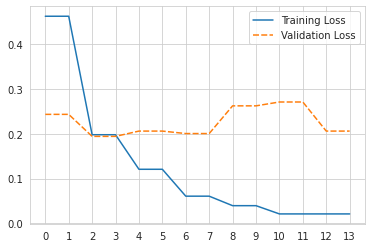

In [110]:
sns.set_style("whitegrid")
ax = sns.lineplot(data = eval_df[['training_loss', 'validation_loss']])
ax.set_xticks(range(len(eval_df)), labels=range(len(eval_df)))
plt.show()

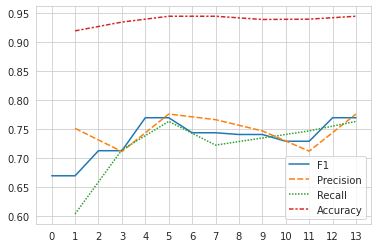

In [111]:
sns.set_style("whitegrid")
ax = sns.lineplot(data = eval_df[['f1', 'precision', 'recall', 'accuracy']])
ax.set_xticks(range(len(eval_df)), labels=range(len(eval_df)))
plt.show()

In [112]:
trainer.create_model_card()